# Plotting
> Plot the result of CF explanations.

In [ ]:
#| default_exp plots

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2
from ipynb_path import *
import warnings
# warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
#| export
from __future__ import annotations
from relax.import_essentials import *
import seaborn as sns
import matplotlib.pyplot as plt
from relax.evaluate import Explanation
from relax.data import TabularDataModule

In [ ]:
#| export
def _process_exp(
    x: jnp.DeviceArray, # Dim: (N, k)
    cf: jnp.DeviceArray, # Dim: (N, k)
    pred_fn: Callable, # Predictive function
    return_valid: bool = False # Return only valid `x`, `cf`, `y_cf` or not
): # Return `x`, `cf`, `y_cf`
    """Process valid data."""
    
    assert x.shape == cf.shape
    assert len(x.shape) > 1

    y_cf = pred_fn(cf).round()
    
    if return_valid:
        y_x = pred_fn(x).round()
        idx = (y_x == y_cf).reshape(-1)
        x, cf, y_cf = x[idx], cf[idx], y_cf[idx]
    return x, cf, y_cf

In [ ]:
#| hide
pred_fn = lambda x: x
x = jnp.zeros((5, 1))
cf = jnp.ones((5, 1))

x, cf, y_cf = _process_exp(x, cf, pred_fn, return_valid=False)
assert x.shape == cf.shape
assert x.shape == (5, 1)
assert y_cf.shape == (5, 1)

x = jnp.zeros((5, 1))
cf = jnp.ones((5, 1))
x, cf, y_cf = _process_exp(x, cf, pred_fn, return_valid=True)
assert x.shape == cf.shape
assert x.shape == (0, 1)
assert y_cf.shape == (0, 1)

x = jnp.zeros((5, 1))
cf = jnp.ones((5, 1))
x = x.at[1].set(1)
x, cf, y_cf = _process_exp(x, cf, pred_fn, return_valid=True)
assert x.shape == cf.shape
assert jnp.allclose(x, jnp.ones(1))
assert jnp.allclose(x, cf)
assert y_cf.shape == (1, 1)


In [ ]:
#| export
def _diff(
    x: jnp.DeviceArray, # Dim: (N, k)
    cf: jnp.DeviceArray, # Dim: (N, k)
    pred_fn: Callable, # Predictive function
    datamodule: TabularDataModule, # Data module
    return_valid: bool = False, # Return only valid `x`, `cf`, `y_cf` or not
    return_outcome_col: bool = True # Return outcome column or not
) -> Tuple[pd.DataFrame, pd.DataFrame]: # Return continuous and categorical differences
    """Calculate differences between `x` and `cf`"""
    
    x, cf, y_cf = _process_exp(x, cf, pred_fn, return_valid)
    # wrap to numpy.array
    x, cf, y_cf = map(np.asarray, (x, cf, y_cf))
    x_inv, cf_inv = map(datamodule.inverse_transform, [x, cf], [y_cf, y_cf])
    cat_idx = datamodule.cat_idx
    cont_diff = pd.DataFrame(
        data=cf[:, :cat_idx] - x[:, :cat_idx],
        columns=datamodule._configs.continous_cols
    ) 
    cat_diff = (~cf_inv.iloc[:, cat_idx:-1].eq(x_inv.iloc[:, cat_idx:-1])).astype(float)
    if return_outcome_col:
        return pd.concat([cont_diff, cf_inv.iloc[:, -1:]], axis=1), \
            pd.concat([cat_diff, cf_inv.iloc[:, -1:]], axis=1)
    else:
        return cont_diff, cat_diff
    # return pd.concat([cont_diff, cat_diff, cf_inv.iloc[:, -1:]], axis=1)


In [ ]:
#| exporti
def _swarmplot(
    cont_diff: pd.DataFrame, ax
):
    target_col = cont_diff.columns[-1]
    cont_diff = cont_diff.melt(
        id_vars=[target_col], value_name='Difference', var_name='Features'
    )
    sns.stripplot(
        y="Features",
        x="Difference",
        data=cont_diff,
        hue=target_col,
        alpha=0.5,
        size=5,
        jitter=0.3,
        ax=ax
    ).set(title="Summary Plot for Continuous Features")
    return ax

In [ ]:
#| exporti
def _stripplot(
    cat_diff: pd.DataFrame, ax
):
    target_col = cat_diff.columns[-1]
    cat_diff = cat_diff.melt(
        id_vars=[target_col], value_name='Difference', var_name='Features'
    )
    # add noise for clear display 
    jitter = 0.3
    delta = np.random.uniform(-jitter/2, jitter/2, len(cat_diff['Difference']))
    cat_diff['Difference'] = cat_diff['Difference'].values + delta
    sns.stripplot(
        y="Features",
        x="Difference",
        data=cat_diff,
        hue=target_col,
        alpha=0.5,
        size=5,
        jitter=0.3,
        ax=ax
    ).set(title="Summary Plot for Categorical Features")
    return ax

In [ ]:
#| export
#| hide
# def swarm_plot(
#     exp: Explanation,
#     sample_frac: float = 1.0,
#     only_valid: bool = False
# ):
#     cont, cat = _diff(
#         exp.X, exp.cfs, exp.pred_fn, exp.data_module, only_valid
#     )
#     return _swarmplot(cont.sample(frac=sample_frac))


# def strip_plot(
#     exp: Explanation,
#     sample_frac: float = 1.0,
#     only_valid: bool = False
# ):
#     cont, cat = _diff(
#         exp.X, exp.cfs, exp.pred_fn, exp.data_module, only_valid
#     )
#     return _stripplot(cat.sample(frac=sample_frac))

In [ ]:
#| export
def summary_plot(
    exp: Explanation, # Explanations to visualize
    sample_frac: float = 1.0, # Sample part of data for visualization
    only_valid: bool = False, # Use only valid data
    figsize=(15, 7) # Figure size
) -> plt.Figure:
    """Globally visualize generated explanations."""

    cont, cat = _diff(
        exp.X, exp.cfs, exp.pred_fn, exp.data_module, only_valid
    )
    fig, (ax1, ax2) = plt.subplots(1, 2)
    _swarmplot(cont.sample(frac=sample_frac), ax1)
    _stripplot(cat.sample(frac=sample_frac), ax2)

    # Resize to create overlap
    fig.set_size_inches(figsize[0], figsize[1])
    plt.subplots_adjust(wspace=.5)

    return fig

In [ ]:
#| exporti
def _barplot(
    diff: pd.Series, ax
):
    sns.barplot(
        x=diff.values, y=diff.index, ax=ax
    ).set(title="Counterfactual Explanations for An Individual Sample")

In [ ]:
#| export
def individual_plot(
    exp: Explanation, # Explanations to visualize
    idx: int, # Index for visualization
    figsize=(15, 7) # Figure plot
) -> plt.Figure:
    """Locally visualize individual explanations."""

    cont, cat = _diff(
        exp.X[idx, :].reshape(1, -1), exp.cfs[idx, :].reshape(1, -1), 
        exp.pred_fn, exp.data_module, return_outcome_col=False
    )
    diff = pd.concat([cont, cat], axis=1)

    # plot individual differences
    fig, ax = plt.subplots()
    _barplot(diff.iloc[0], ax)
    fig.set_size_inches(figsize[0], figsize[1])
    return fig

## Example

We first use `VanillaCF` to generate `Explanation`.

In [ ]:
from relax.utils import load_json
from relax.module import PredictiveTrainingModule
from relax.trainer import train_model
from relax.evaluate import generate_cf_explanations
from relax.methods import VanillaCF

In [ ]:
#| output: false
# load configs
configs = load_json('assets/configs/data_configs/adult.json')
m_configs = configs['mlp_configs']
data_configs = configs['data_configs']
t_configs = dict(n_epochs=10, batch_size=256)

# load data and model
dm = TabularDataModule(data_configs)
model = PredictiveTrainingModule(m_configs)

# train predictive models
params, opt_state = train_model(model, dm, t_configs)
pred_fn = lambda x, params, prng_key: model.forward(params, prng_key, x, is_training=False)

# generate explanations
exp = generate_cf_explanations(
    VanillaCF(), dm, pred_fn, 
    pred_fn_args=dict(params=params, prng_key=random.PRNGKey(0))
)

/home/birk/code/cfnet/cfnet/_ckpt_manager.py:48: UserWarning: `monitor_metrics` is not specified in `CheckpointManager`. No checkpoints will be stored.
  "`monitor_metrics` is not specified in `CheckpointManager`. No checkpoints will be stored."
100%|██████████| 1000/1000 [00:05<00:00, 187.31it/s]


In [ ]:
#| hide
cont_diff, cat_diff = _diff(exp.X[:5], exp.cfs[:5], exp.pred_fn, exp.data_module, return_outcome_col=True)
assert len(cont_diff) == len(cat_diff)
assert len(cont_diff) == 5
assert len(cont_diff.columns) + len(cat_diff.columns) == len(exp.data_module.data.columns) + 1

cont_diff, cat_diff = _diff(exp.X[:5], exp.cfs[:5], exp.pred_fn, exp.data_module, return_outcome_col=False)
assert len(cont_diff) == len(cat_diff)
assert len(cont_diff) == 5
assert len(cont_diff.columns) + len(cat_diff.columns) == len(exp.data_module.data.columns) - 1


To visualize individual explanation: 

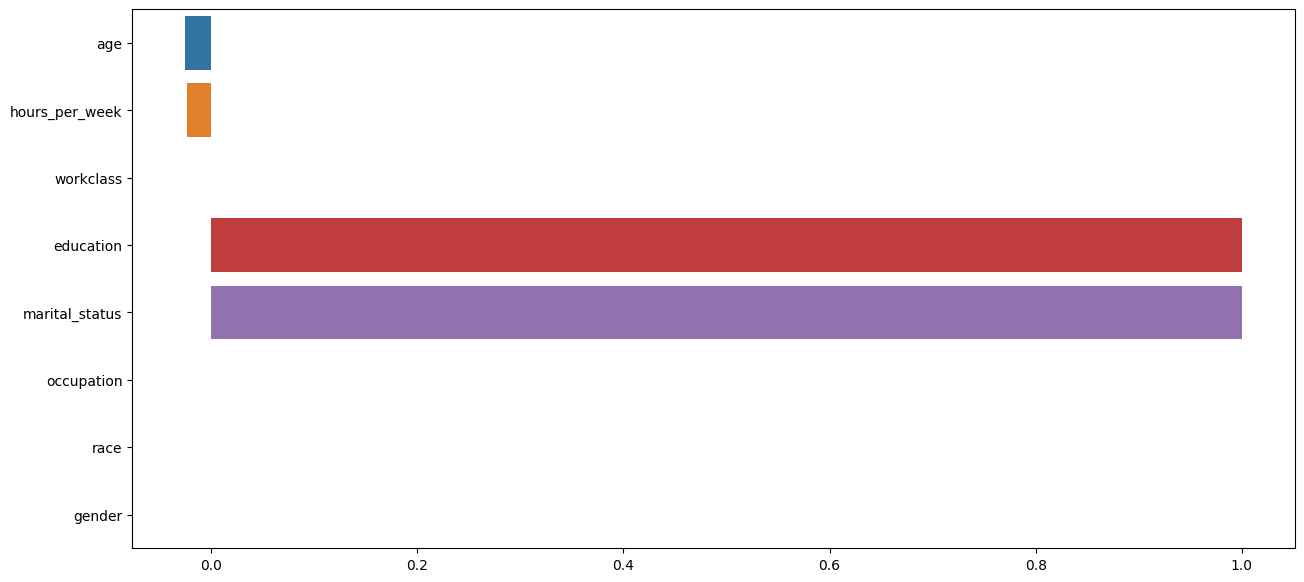

In [ ]:
# this visualize the differences between `exp.X[0]` and `exp.cfs[0]`
fig = individual_plot(exp, idx=0)

To analyze the entire explanation distribution:

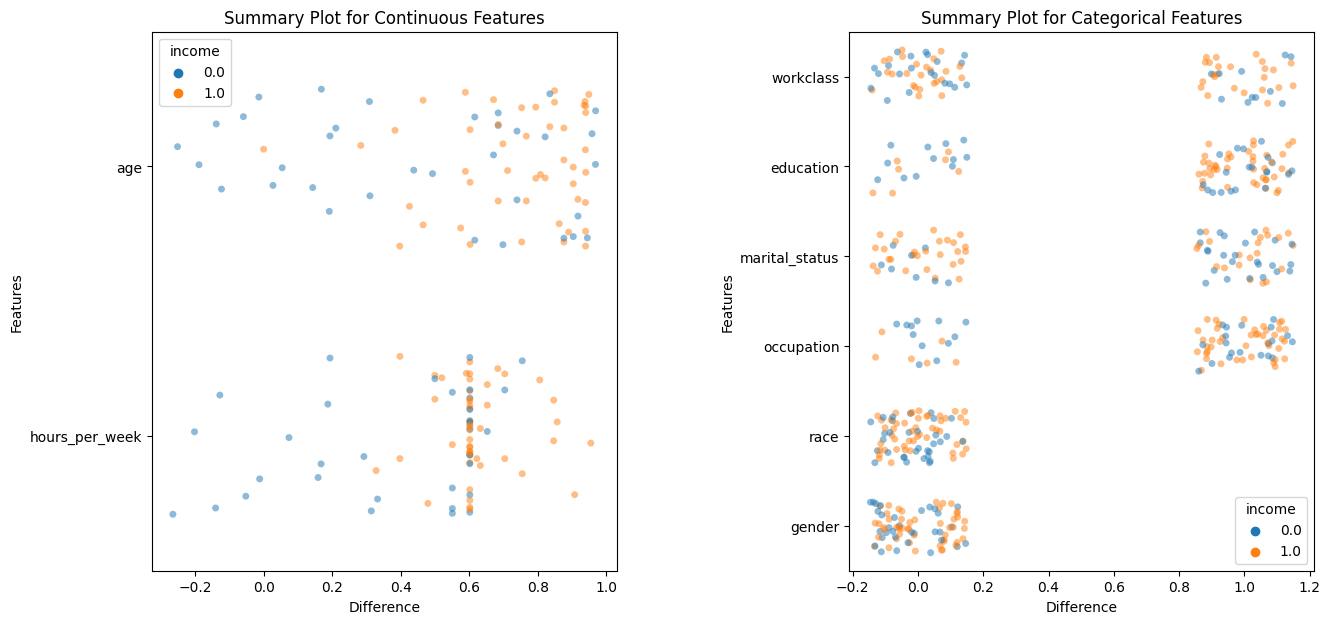

In [ ]:
fig = summary_plot(exp, sample_frac=0.01)

In [ ]:
#| hide
@deprecated
def _swarmplot(
    diff: pd.DataFrame,
    use_valid: bool = False
): 
    target_col = diff.columns[-1]
    diff = diff.melt(
        id_vars=[target_col], value_name='Difference', var_name='Features'
    )
    fig = px.strip(
        diff, x='Difference', y='Features', color=target_col, stripmode='group', 
        # height=4000, width=1000
    )
    # https://community.plotly.com/t/shap-like-bee-swarm-plots/68015/3
    fig = (
        fig.update_layout(
            xaxis=dict(showgrid=True, gridcolor='WhiteSmoke', zerolinecolor='Gainsboro'),
            yaxis=dict(showgrid=True, gridcolor='WhiteSmoke', zerolinecolor='Gainsboro'),
            plot_bgcolor='white', boxgap=0
        ).update_traces(jitter=1.0)
    )
    return fig

In [ ]:
#| hide
def swarmplot(
    cf_exp: Explanation, # CF Explanations
    plot_name: str = "Swarm Plot",  # The name for the plot
    sample_num: int = 100,  # The number of sample for the plot
    seed: int = 42,  # Seed for PRG for random sampling
    separate_class: bool = True, # Whether to separate the data based on the classifier result
):
    """Plot diffs between factual and counterfactual for continuous features."""

    X = cf_exp.X
    cfs = cf_exp.cfs
    dm = cf_exp.data_module
    pred_fn = cf_exp.pred_fn

    # Compute the difference of continuous data between factual and counterfactual
    X_inverse = dm.normalizer.inverse_transform(X[:, :dm.cat_idx])
    cf_inverse = dm.normalizer.inverse_transform(cfs[:, :dm.cat_idx])
    
    diff = jnp.subtract(cf_inverse, X_inverse)

    # Configuration for randomized sampling
    data_len: int = len(X)  # Length of the dataset
    key_seq: hk.PRNGSequence = hk.PRNGSequence(
        seed
    )  # Random number sequence
    key_seq.reserve(
        sample_num
    )  # Generate some random number as key based on the number of batches
    indices: jnp.array = jnp.arange(
        data_len
    )  # Available indices in the dataset
    y_pred = pred_fn(X).reshape(-1, 1)
    y_pred = y_pred.reshape(-1)
    y_pred = np.rint(y_pred)
    if 1 in y_pred:
        one_indices = jnp.array([i for i, x in enumerate(y_pred) if x == 1])
    if 0 in y_pred:
        zero_indices = jnp.array([i for i, x in enumerate(y_pred) if x == 0])

    # Preparing the data for plotting
    key = next(key_seq) # Obtain a random key from the sequence
    indices = jax.random.permutation(key, indices)  # Shuffled available indices
    if not separate_class:
        sampled_data = jnp.asarray([diff[i] for i in indices[: sample_num]]) # sampled data
        data = dict()  # Data for the plot
        for f in range(len(dm.continous_cols)):
            data[dm.continous_cols[f]] = sampled_data[:,f]
        df = pd.DataFrame(data)

        # Create the plot
        sns.set(style="whitegrid")
        ax = sns.swarmplot(
                x="variable",
                y="value",
                data=df.melt(),
                alpha=0.5,
                size=5).set(title=plot_name, xlabel='Features', ylabel='Difference')
        plt.show(ax)
    else:
        if 1 in y_pred:
            one_indices = jax.random.permutation(key, one_indices) # Shuffle available indices
            sampled_data_one = jnp.asarray(diff[one_indices[: sample_num]]) # sampled data
            data_one = dict()  # Data for the plot
        if 0 in y_pred:
            zero_indices = jax.random.permutation(key, zero_indices) # Shuffle available indices
            sampled_data_zero = jnp.asarray(diff[zero_indices[: sample_num]]) # sampled data
            data_zero = dict()  # Data for the plot

        for f in range(len(dm.continous_cols)):
            if 0 in y_pred:
                data_zero[dm.continous_cols[f]] = sampled_data_zero[:,f]
            if 1 in y_pred:
                data_one[dm.continous_cols[f]] = sampled_data_one[:,f]
        if 1 in y_pred:
            df_one = pd.DataFrame(data_one)
        if 0 in y_pred:
            df_zero = pd.DataFrame(data_zero)

        # Create the plot
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(1, 2, figsize=(18, 10))
        if 0 in y_pred:
            sns.swarmplot(
                    x="variable",
                    y="value",
                    data=df_zero.melt(),
                    alpha=0.5,
                    size=5,
                    ax=axes[0]).set(title=plot_name+" Zero to One", xlabel='Features', ylabel='Difference')
        if 1 in y_pred:
            sns.swarmplot(
                    x="variable",
                    y="value",
                    data=df_one.melt(),
                    alpha=0.5,
                    size=5,
                    ax=axes[1]).set(title=plot_name+" One to Zero", xlabel='Features', ylabel='Difference')
        plt.show(fig)

In [ ]:
#| hide
def stripplot(
        cf_exp: Explanation, # CF Explanations
        plot_name: str,  # The name for the plot
        sample_num: int,  # The number of sample for the plot
        seed: int,  # Seed for PRG for random sampling
        separate_class: bool, # Whether to separate the data based on the classifier result
    ):
    """Print a strip plot of the difference of discrete data between factual and counter factual data."""
    X = cf_exp.X
    cfs = cf_exp.cfs
    dm = cf_exp.data_module
    pred_fn = cf_exp.pred_fn

    # Obtain discrete data
    X_dis = X[:,dm.cat_idx:]
    cf_dis = cfs[:,dm.cat_idx:]

    # Configuration for randomized sampling
    data_len: int = len(X)  # Length of the dataset
    key_seq: hk.PRNGSequence = hk.PRNGSequence(
        seed
    )  # Random number sequence
    key_seq.reserve(
        sample_num
    )  # Generate some random number as key based on the number of batches
    indices: jnp.array = jnp.arange(
        data_len
    )  # Available indices in the dataset
    y_pred = pred_fn(X).reshape(-1, 1)
    y_pred = y_pred.reshape(-1)
    y_pred = np.rint(y_pred)
    if 0 in y_pred:
        zero_indices = jnp.array([i for i, x in enumerate(y_pred) if x == 0])
    if 1 in y_pred:
        one_indices = jnp.array([i for i, x in enumerate(y_pred) if x == 1])

    key = next(key_seq) # Obtain a random key from the sequence
    # For sparating the points on the plot
    jitter = 0.3
    delta = np.random.uniform(-jitter / 2, jitter / 2, sample_num)
    if not separate_class:
        indices = jax.random.permutation(key, indices) # Shuffle available indices
        sampled_data = jnp.asarray(X_dis[indices[: sample_num]]) # Sampled factual data
        sampled_cfs = jnp.asarray(cf_dis[indices[: sample_num]]) # Sampled counterfactual data
        data = dict() # Data for the plot
        for feature in dm.discret_cols:
            data[feature] = []

        # Preparing the data for plotting
        for i in range(sample_num):
            cat_idx = 0
            for f in range(len(dm.cat_arrays)):
                feature = dm.discret_cols[f]
                l = len(dm.cat_arrays[f])
                cat_end = cat_idx + l
                if jnp.array_equal(sampled_data[i][cat_idx:cat_end], sampled_cfs[i][cat_idx:cat_end]):
                    data[feature].append(0+delta[i])
                else:
                    data[feature].append(1+delta[i])
                cat_idx += l

        df = pd.DataFrame(data)
        sns.set(style="whitegrid")
        ax = sns.stripplot(
                y="variable",
                x="value",
                data=df.melt(),
                alpha=0.5,
                size=7,
                jitter=jitter).set(title=plot_name, xlabel='Difference', ylabel='Features')
        plt.show(ax)
    else:
        if 0 in y_pred:
            zero_indices = jax.random.permutation(key, zero_indices) # Shuffle available indices
            zero_sampled_data = jnp.asarray(X_dis[zero_indices[: sample_num]]) # Sampled factual data
            zero_sampled_cfs = jnp.asarray(cf_dis[zero_indices[: sample_num]]) # Sampled counterfactual data
            data_zero = dict() # Data for the plot
        if 1 in y_pred:
            one_indices = jax.random.permutation(key, one_indices) # Shuffle available indices
            one_sampled_data = jnp.asarray(X_dis[one_indices[: sample_num]]) # Sampled factual data
            one_sampled_cfs = jnp.asarray(cf_dis[one_indices[: sample_num]]) # Sampled counterfactual data
            data_one = dict() # Data for the plot

        data_zero = {}
        data_one = {}

        for feature in dm.discret_cols:
            if 1 in y_pred:
                data_one[feature] = []
            if 0 in y_pred:
                data_zero[feature] = []

        # Preparing the data for plotting
        for i in range(sample_num):
            cat_idx = 0
            for f in range(len(dm.cat_arrays)):
                feature = dm.discret_cols[f]
                l = len(dm.cat_arrays[f])
                cat_end = cat_idx + l
                if data_zero:
                    if jnp.array_equal(zero_sampled_data[i][cat_idx:cat_end], zero_sampled_cfs[i][cat_idx:cat_end]):
                        data_zero[feature].append(0+delta[i])
                    else:
                        data_zero[feature].append(1+delta[i])
                if data_one:
                    if jnp.array_equal(one_sampled_data[i][cat_idx:cat_end], one_sampled_cfs[i][cat_idx:cat_end]):
                        data_one[feature].append(0+delta[i])
                    else:
                        data_one[feature].append(1+delta[i])
                cat_idx += l
        if data_zero:
            df_zero = pd.DataFrame(data_zero)
        if data_one:
            df_one = pd.DataFrame(data_one)
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(1, 2, figsize=(18, 10))
        if data_zero:
            sns.stripplot(
                    ax=axes[0],
                    y="variable",
                    x="value",
                    data=df_zero.melt(),
                    alpha=0.5,
                    size=7,
                    jitter=jitter).set(title=plot_name+" Zero to One", xlabel='Difference', ylabel='Features')
        if data_one:
            sns.stripplot(
                    ax=axes[1],
                    y="variable",
                    x="value",
                    data=df_one.melt(),
                    alpha=0.5,
                    size=7,
                    jitter=jitter).set(title=plot_name+" One to Zero", xlabel='Difference', ylabel='Features')
        plt.show(fig)